# Day 11

## Part One:

On the way to Jupiter, you're pulled over by the Space Police.

"Attention, unmarked spacecraft! You are in violation of Space Law! All spacecraft must have a clearly visible registration identifier! You have 24 hours to comply or be sent to Space Jail!"

Not wanting to be sent to Space Jail, you radio back to the Elves on Earth for help. Although it takes almost three hours for their reply signal to reach you, they send instructions for how to power up the emergency hull painting robot and even provide a small Intcode program (your puzzle input) that will cause it to paint your ship appropriately.

There's just one problem: you don't have an emergency hull painting robot.

You'll need to build a new emergency hull painting robot. The robot needs to be able to move around on the grid of square panels on the side of your ship, detect the color of its current panel, and paint its current panel black or white. (All of the panels are currently black.)

The Intcode program will serve as the brain of the robot. The program uses input instructions to access the robot's camera: provide 0 if the robot is over a black panel or 1 if the robot is over a white panel. Then, the program will output two values:

First, it will output a value indicating the color to paint the panel the robot is over: 0 means to paint the panel black, and 1 means to paint the panel white.
Second, it will output a value indicating the direction the robot should turn: 0 means it should turn left 90 degrees, and 1 means it should turn right 90 degrees.
After the robot turns, it should always move forward exactly one panel. The robot starts facing up.

The robot will continue running for a while like this and halt when it is finished drawing. Do not restart the Intcode computer inside the robot during this process.

For example, suppose the robot is about to start running. Drawing black panels as ., white panels as #, and the robot pointing the direction it is facing (< ^ > v), the initial state and region near the robot looks like this:
<pre>
.....
.....
..^..
.....
.....
</pre>
The panel under the robot (not visible here because a ^ is shown instead) is also black, and so any input instructions at this point should be provided 0. Suppose the robot eventually outputs 1 (paint white) and then 0 (turn left). After taking these actions and moving forward one panel, the region now looks like this:
<pre>
.....
.....
.<#..
.....
.....
</pre>
Input instructions should still be provided 0. Next, the robot might output 0 (paint black) and then 0 (turn left):
<pre>
.....
.....
..#..
.v...
.....
</pre>
After more outputs (1,0, 1,0):
<pre>
.....
.....
..^..
.##..
.....
</pre>
The robot is now back where it started, but because it is now on a white panel, input instructions should be provided 1. After several more outputs (0,1, 1,0, 1,0), the area looks like this:
<pre>
.....
..<#.
...#.
.##..
.....
</pre>
Before you deploy the robot, you should probably have an estimate of the area it will cover: specifically, you need to know the number of panels it paints at least once, regardless of color. In the example above, the robot painted 6 panels at least once. (It painted its starting panel twice, but that panel is still only counted once; it also never painted the panel it ended on.)

Build a new emergency hull painting robot and run the Intcode program on it. How many panels does it paint at least once?

To begin, get your puzzle input.



In [ ]:
"""
import sys
sys.path.insert(0, "../day9/")

from day9.ipynb import diagnosis_code
"""

In [3]:
# Puzzle Input
intcode = list(map(int, open('input.txt', 'r').read().split(',')))
list_of_zeros = [0] * 10000000
intcode_long = intcode + list_of_zeros

In [4]:
def parse_long_direction(direction):
    shortopcode = str(direction).zfill(5)
    param_1_mode, param_2_mode, param_3_mode, opcode = int(shortopcode[2]), int(shortopcode[1]), int(shortopcode[0]), int(shortopcode[-2:])
    direction_list = [opcode, param_1_mode, param_2_mode, param_3_mode]
    return direction_list

In [8]:
def diagnosis_code(program, opcode_index=0, relative_base=0, output=0, input_value = 0):
    program_copy = program.copy()
    first_time = 0
    while True:
        opcode = program_copy[opcode_index]
        direction = parse_long_direction(opcode)[0]
        elements = []
        if direction in {1, 2, 7, 8}:
            elements_length = 3
        elif direction in {3, 4, 9}:
            elements_length = 1
        elif direction in {5,6}:
            elements_length = 2
        for i in range(1,elements_length+1):
            if parse_long_direction(opcode)[i] == 0:
                elements.append(program_copy[opcode_index + i])
            elif parse_long_direction(opcode)[i] == 1:
                elements.append(opcode_index + i)
            elif parse_long_direction(opcode)[i] == 2:
                elements.append(program_copy[opcode_index + i] + relative_base)
        if direction == 99:
            halted = 1
            return output, program_copy, opcode_index, halted, relative_base   
        elif direction == 1:
            program_copy[elements[2]] = program_copy[elements[0]] + program_copy[elements[1]]
            opcode_index +=4
        elif direction == 2:
            program_copy[elements[2]] = program_copy[elements[0]] * program_copy[elements[1]]
            opcode_index +=4
        elif direction == 3:
            program_copy[elements[0]] = input_value
            opcode_index +=2
        elif direction == 4:
            output = program_copy[elements[0]]
            opcode_index +=2
            halted = 0
            return output, program_copy, opcode_index, halted, relative_base
        elif direction == 5:
            if program_copy[elements[0]] != 0:
                opcode_index = program_copy[elements[1]]
            else:
                opcode_index +=3
        elif direction == 6:
            if program_copy[elements[0]] == 0:
                opcode_index = program_copy[elements[1]]
            else:
                opcode_index +=3
        elif direction == 7:
            if program_copy[elements[0]] < program_copy[elements[1]]:
                program_copy[elements[2]] = 1
                opcode_index +=4
            else:
                program_copy[elements[2]] = 0
                opcode_index +=4
        elif direction == 8:
            if program_copy[elements[0]] == program_copy[elements[1]]:
                program_copy[elements[2]] = 1
                opcode_index +=4
            else:
                program_copy[elements[2]] = 0
                opcode_index +=4
        elif direction == 9:
            relative_base += program_copy[elements[0]]
            opcode_index +=2


In [14]:
from collections import defaultdict 

def count_painted_tiles(program):
    painting_position = (0,0)
    change_direction_pointer_left = {"L": "D", "R": "U", "U": "L", "D": "R"}
    change_direction_pointer_right = {"L": "U", "R": "D", "U": "R", "D": "L"}
    previous_direction = ["U"]
    #move_dictionary = {"L": (-1, 0), "R": (1,0), "U": (0,1), "D": (0,-1)}
    #painted_panels = {}
    painted_panels = defaultdict(int)
    #directions = [(0,1), (1,0), (-1,0), (0,-1)]
    step = 0 
    output_for_painting, program_copy, new_opcode_index, halted, relative_base = diagnosis_code(program, 0, 0, 0)
    input_values = [0]
    while True:
        if halted == 1:
            return painted_panels, len(painted_panels)
        elif step % 2 == 0:
            if output_for_painting == 1:
                painted_panels[painting_position] += 1
                input_values.append(1)
               # if painting_position not in painted_panels.keys():
                #    print("I painted")
                #    painted_panels[painting_position] = 1   
            else:
                #print("I painted")
                painted_panels[painting_position] += 1
                input_values.append(0)
            output_for_direction, program_copy, new_opcode_index, halted, relative_base = diagnosis_code(program_copy, new_opcode_index, relative_base, output_for_painting, input_values[-1])
            step +=1
        elif step % 2 == 1:
            print(f"output_for_direction is {output_for_direction}")
            if output_for_direction == 1:
                position = change_direction_pointer_right[previous_direction[int((step-1)/2)]]
                print("I went right")
                previous_direction.append(position)
            else:
                position = change_direction_pointer_left[previous_direction[int((step-1)/2)]]
                print("I went left")
                previous_direction.append(position)
            if position == "R":
                painting_position = (painting_position[0] + 1, painting_position[1])
            elif position == "L":
                painting_position = (painting_position[0] - 1, painting_position[1])
            elif position == "U":
                painting_position = (painting_position[0], painting_position[1] + 1)
            elif position == "D":
                painting_position = (painting_position[0], painting_position[1] - 1)
            output_for_painting, program_copy, new_opcode_index, halted, relative_base = diagnosis_code(program_copy, new_opcode_index, relative_base, output_for_direction, input_values[-1])
            step +=1
        else:
            print("error")

In [15]:
count_painted_tiles(intcode_long)

output_for_direction is 0
I went left
output_for_direction is 0
I went left
output_for_direction is 0
I went left
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 0
I went left
output_for_direction is 0
I went left
output_for_direction is 0
I went left
output_for_direction is 0
I went left
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went right
output_for_direction is 1
I went

KeyboardInterrupt: 

In [ ]:
license_plate = []

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


X = [x.real for x in cnums]
Y = [x.imag for x in cnums]
plt.scatter(X,Y, color='red')
plt.show()

In [ ]:
                """
                change_direction_pointer += 1
                change_direction_pointer = change_direction_pointer % 4
                painting_position = (painting_position[0] + directions[change_direction_pointer][0], 
                                     painting_position[1] + directions[change_direction_pointer][1])
                
            else:
                change_direction_pointer -=1
                change_direction_pointer = change_direction_pointer % 4
                painting_position = (painting_position[0] + directions[change_direction_pointer][0], 
                                     painting_position[1] + directions[change_direction_pointer][1])
                """

In [ ]:

"""

def paint_car(program):
    list_of_directions=[]
    directions = diagnosis_code(program, input_value = 1)
    i = 10
    j = 10
    for k, direction in enumerate(directions):
        if k % 2 == 1:
            if direction == 1:
                print(f"hi and {k}")
                painted_panels[]
                #license_plate[i][j] = 1
            else:
                print(f"hi and {k}")
                license_plate[i][j] = 0
        else:    
            if directions[k] == 0:
                list_of_directions.append("L")
                
                i +=1
            else:
                print(f"hey and turned right {k}")
                i -=1
    return(license_plate)
"""

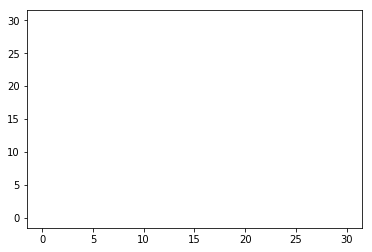

In [78]:
xvalues = np.array([i for i in range(0,31)])
yvalues = np.array([i for i in range(0,31)])

xx, yy = np.meshgrid(xvalues, yvalues)

plt.plot(xx, yy, marker='.', color='k', linestyle='none')

x



In [72]:
initial_license_plate = [0] * 2500
license_plate = [initial_license_plate[i*50:(i+1)*50] for i in range(50)]


In [73]:
print(license_plate)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [70]:
paint_car(intcode)

hey and turned left 0
hi and 1
hey and turned right 2
hi and 3
hey and turned right 4
hi and 5
hey and turned left 6
hi and 7
hey and turned left 8
hi and 9
hey and turned left 10
hi and 11
hey and turned left 12
hi and 13
hey and turned right 14
hi and 15
hey and turned right 16
hi and 17
hey and turned left 18
hi and 19
hey and turned left 20
hi and 21
hey and turned right 22
hi and 23
hey and turned right 24
hi and 25
hey and turned left 26
hi and 27
hey and turned left 28
hi and 29
hey and turned right 30
hi and 31
hey and turned left 32
hi and 33
hey and turned right 34
hi and 35
hey and turned left 36
hi and 37
hey and turned left 38
hi and 39
hey and turned left 40
hi and 41
hey and turned left 42
hi and 43
hey and turned left 44
hi and 45
hey and turned left 46
hi and 47
hey and turned left 48
hi and 49
hey and turned right 50
hi and 51
hey and turned left 52
hi and 53
hey and turned right 54
hi and 55
hey and turned right 56
hi and 57
hey and turned left 58
hi and 59
hey and t

IndexError: list index out of range